In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

[[4.470770e-01 8.250000e+02]
 [6.014580e-01 1.230000e+03]
 [9.430620e-01 2.065000e+03]
 [1.218955e+00 2.925000e+03]
 [1.208824e+00 3.300000e+03]
 [1.161946e+00 4.150000e+03]
 [1.506875e+00 4.500000e+03]
 [1.585414e+00 4.800000e+03]
 [1.150748e+00 2.850000e+03]
 [4.972340e-01 7.600000e+02]
 [4.055360e-01 4.800000e+02]]
[[2.23675116e+00 8.25000000e+02]
 [1.66262648e+00 1.23000000e+03]
 [1.06037567e+00 2.06500000e+03]
 [8.20374829e-01 2.92500000e+03]
 [8.27250286e-01 3.30000000e+03]
 [8.60625193e-01 4.15000000e+03]
 [6.63625052e-01 4.50000000e+03]
 [6.30750075e-01 4.80000000e+03]
 [8.68999990e-01 2.85000000e+03]
 [2.01112555e+00 7.60000000e+02]
 [2.46587233e+00 4.80000000e+02]]
[[ 2.67818186e-01 -6.01471552e+02  5.17570509e+02]
 [-6.01471552e+02  1.41701072e+06 -1.22815137e+06]
 [ 5.17570509e+02 -1.22815137e+06  1.08120097e+06]]


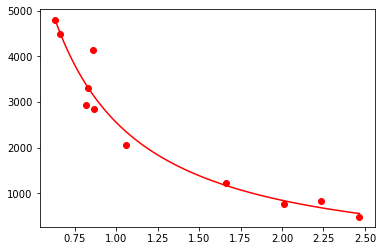

In [15]:
# Load data using pandas
data_sample = pd.read_csv('data.csv', header=None).to_numpy()
print(data_sample)
# invert first column 
data_sample[:,0] = 1/data_sample[:,0]

print(data_sample)

def func(x, a, b,c):
    return b/x**a + c

popt, pcov = curve_fit(func, data_sample[:,0], data_sample[:,1])
print(pcov)

x = np.linspace(np.min(data_sample[:,0]), np.max(data_sample[:,0]), 100)

plt.yscale('log')
plt.plot(x, func(x, *popt), 'r-')
plt.plot(data_sample[:,0], data_sample[:,1], 'ro')

In [11]:
func(0.81,*popt)

3340.6900505856256